# Spectral Sounds: Unveiling Music Genre Classification Through Audio Spectrograms

## Introduction
With the dominance of digital music streaming, music genre classification is an increasingly important way to develop algorithms for suggesting new songs to users. Without a way to analyze the abstract aspects of each song such as mood and tone, these algorithms must be able to make accurate predictions based only on the quantitative characteristics of the audio itself.

Hence, we aim to answer the following research question: 

> *Can we predict the genre of a song based on its audio spectrograph information?*

In particular, we will focus on the **classical**, **jazz**, **pop**, and **rock** music genres.

### Dataset Description
We will be using the *Music Genre Classification* dataset by Andrada on [Kaggle](https://www.kaggle.com/datasets/andradaolteanu/gtzan-dataset-music-genre-classification). It includes observations for 1000 30-second `.wav` audio snippets labeled by genre, with 60 variables that describe the mean and variance of different aspects of each audio spectrogram (visual waveform). The following table goes over the information included in the data set:

| Variable                                                  | Unit                         | Description                                                                   |
|-----------------------------------------------------------|------------------------------|-------------------------------------------------------------------------------|
| `filename`                                                |                              | name of the file                                                              |
| `length`                                                  | bytes                        | size of the file                                                              |
| `chroma_stft_mean`, `chroma_stft_var`                     | normalized semitones, [0, 1] | chroma features; distribution of musical pitches                              |
| `rms_mean`, `rms_var`                                     | dB                           | root mean square; perceived loudness                                          |
| `spectral_centroid_mean`, `spectral_centroid_var`         | Hz                           | average frequency                                                             |
| `spectral_bandwidth_mean`, `spectral_bandwidth_var`       | Hz                           | average spread of frequencies                                                 |
| `rolloff_mean`, `rolloff_var`                             | Hz                           | frequency below which lies 85% of the signal                                  |
| `zero_crossing_rate_mean`, `zero_crossing_rate_var`       | crossings per byte           | rate at which the signal changes its sign                                     |
| `harmony_mean`, `harmony_var`                             | unitless, [-1, 1]            | the “harmonic” component of the song                                          |
| `perceptr_mean`, `perceptr_var`                           | unitless, [-1, 1]            | the “percussive” component of the song                                        |
| `tempo`                                                   | beats per minute             | the speed of the song                                                         |
| `mfcc1_mean` to `mfcc20_mean`, `mfcc1_var` - `mfcc20_var` | mels                         | frequency cepstral coefficients; distribution of certain human vocal features |
| `label`                                                   |                              | music genre                                                                   |

## Methods

!TODO

Overview what we are doing, how we plan on doing it, and the rationale behind it

also discuss any concerns that may occur and how we plan on addressing them

For this exploration, we will omit the harmony and perceptr values as they are not standarized measurements for audio spectrogram data. Moreover, we also ommit any mfcc values as they are generally reserved for the analysis of smaller audio subsets. 

### Preliminary Data Processing
The preliminary data processing includes:
1. Loading the dataset from the URL;
2. Cleaning and wrangling the data into a tidy format;
3. Splitting the data into training and testing data; and
4. Producing summary statistics for the training data.

#### 0. Setting up the environment

In [1]:
# Load required libraries.
library(tidyverse)
library(tidymodels)
library(RColorBrewer)
library(ggplot2)
library(GGally)
library(dplyr) 

# Initalize constants for analysis.
DATASET_URL <- "https://raw.githubusercontent.com/arthu-rguo/dsci-100-proj/master/features_30_sec.csv"
GENRES <- c("classical", "jazz", "pop", "rock")
VARIABLES <- c("chroma_stft_mean", "chroma_stft_var", "rms_mean", "rms_var", "spectral_centroid_mean", "spectral_centroid_var", "spectral_bandwidth_mean", 
               "spectral_bandwidth_var", "rolloff_mean", "rolloff_var", "zero_crossing_rate_mean", "zero_crossing_rate_var")

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.6     ✔ purrr   0.3.4
✔ tibble  3.1.7     ✔ dplyr   1.0.9
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.0     ✔ rsample      1.0.0
✔ dials        1.0.0     ✔ tune         1.0.0
✔ infer        1.0.2     ✔ workflows    1.0.0
✔ modeldata    1.0.0     ✔ workflowsets 1.0.0
✔ parsnip      1.0.0     ✔ yardstick    1.0.0
✔ recipes      1.0.1     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::filter()
✖ recipes::fixed()  masks stringr::fixed()
✖ dplyr::lag()      masks stats::lag()
✖ yardstick::spec() masks r

#### 1. Loading the dataset from the URL

In [2]:
# Load and tidy up the dataset.
music_data_raw <- read_csv(DATASET_URL)

Rows: 1000 Columns: 60
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (2): filename, label
dbl (58): length, chroma_stft_mean, chroma_stft_var, rms_mean, rms_var, spec...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


#### 2. Cleaning and wrangling the data into a tidy format
The data is filtered to keep only the genres and variables relevant for our analysis. The label column is also converted to a factor data type.

In [3]:
# Select only relevant genres and predictors.
music_data <- music_data_raw |>
    select(label, all_of(VARIABLES)) |>
    filter(label %in% GENRES) |>
    mutate(label = as_factor(label)) |>
    relocate(label)
    
head(music_data)

label,chroma_stft_mean,chroma_stft_var,rms_mean,rms_var,spectral_centroid_mean,spectral_centroid_var,spectral_bandwidth_mean,spectral_bandwidth_var,rolloff_mean,rolloff_var,zero_crossing_rate_mean,zero_crossing_rate_var
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
classical,0.2523919,0.08415318,0.03624489,0.0002207507,1505.166,44457.89,1559.006,43682.97,2716.306,299398.3,0.09822270,0.0004313938
classical,0.2149950,0.08500956,0.03062517,0.0001609684,1360.644,61611.21,1441.243,32378.73,2387.729,368797.1,0.08776563,0.0006296792
classical,0.2779581,0.08375870,0.04385955,0.0001926202,1490.275,38993.34,1600.116,31200.90,2785.294,274835.4,0.09004578,0.0003952271
classical,0.2342293,0.08345093,0.02944208,0.0003565407,1526.630,91344.31,1499.439,60196.23,2916.000,499393.9,0.10894638,0.0011608430
classical,0.2215738,0.08499950,0.04231631,0.0002093876,1705.563,68132.45,1646.064,25963.46,3174.932,333266.9,0.11285717,0.0008350001
classical,0.2685303,0.08254110,0.04326224,0.0005845473,1431.055,74049.94,1558.113,39297.27,2835.996,305081.8,0.07521004,0.0006178058


#### 3. Splitting the data into training and testing data
The data is split into 75% training and 25% testing data. Due to the large amount of data available, we use 10-fold cross validation to minimize bias when tuning parameters later on. A random seed is also set to ensure the data is split in a reproducible manner.

In [4]:
set.seed(45)

# Split the dataset into training and testing sets.
music_split <- music_data |> 
    initial_split(props = 0.75, strata = label)

music_training_data <- training(music_split)
music_testing_data <- testing(music_split)

music_vfold <- music_training_data |>
    vfold_cv(v = 10, strata = label)

# Count the number of observations in each subset.
paste("Number of observations in training data: ", pull(count(music_training_data)))
paste("Number of observations in testing data: ", pull(count(music_testing_data)))

[1] "Number of observations in training data:  300"

[1] "Number of observations in testing data:  100"

#### 4. Producing summary statistics for the training data
We check for `null` and `N/A` values in the training data and compute the mean and standard deviation for each variable for each genre.

In [5]:
# Count the number of null and N/A values.
paste("Number of null values: ", sum(map_df(music_training_data, is.null)))
paste("Number of N/A values: ", sum(map_df(music_training_data, is.na)))

# Compute means and standard deviations.
music_training_data |> 
    group_by(label) |> 
    summarize(count = n(), across(-count, median))

music_training_data |> 
    group_by(label) |> 
    summarize(count = n(), across(-count, sd))

[1] "Number of null values:  0"

[1] "Number of N/A values:  0"

label,count,chroma_stft_mean,chroma_stft_var,rms_mean,rms_var,spectral_centroid_mean,spectral_centroid_var,spectral_bandwidth_mean,spectral_bandwidth_var,rolloff_mean,rolloff_var,zero_crossing_rate_mean,zero_crossing_rate_var
<fct>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
classical,75,0.2572901,0.08454720,0.03321557,0.0003957757,1358.547,92293.65,1525.335,57765.86,2496.203,434071.7,0.07583880,0.0006539051
jazz,75,0.2848820,0.08990471,0.07813579,0.0012968302,1670.233,208146.31,1920.377,99174.96,3375.925,1187442.1,0.06482661,0.0008585862
pop,75,0.3945035,0.08944974,0.20324428,0.0061728158,3126.642,840186.05,3045.880,167148.24,6840.997,2839278.4,0.12851842,0.0055676931
rock,75,0.3903474,0.08462719,0.12693483,0.0014599054,2312.160,359750.11,2210.479,104672.97,4690.042,1477241.9,0.11589710,0.0022686079


label,count,chroma_stft_mean,chroma_stft_var,rms_mean,rms_var,spectral_centroid_mean,spectral_centroid_var,spectral_bandwidth_mean,spectral_bandwidth_var,rolloff_mean,rolloff_var,zero_crossing_rate_mean,zero_crossing_rate_var
<fct>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
classical,75,0.04603775,0.003153684,0.03208652,0.0007493197,353.3528,92786.38,258.3957,80791.31,766.6167,610595.2,0.02654922,0.0007384678
jazz,75,0.05140620,0.004806740,0.04773085,0.0011615650,676.9212,279076.46,545.8502,68723.49,1519.5687,1171326.4,0.03907997,0.0025530035
pop,75,0.05480653,0.005616572,0.05973232,0.0049347836,598.0603,402143.56,326.0680,77224.47,1258.7872,1244800.0,0.03682496,0.0042363510
rock,75,0.03894887,0.006347585,0.04369940,0.0012154138,502.5484,291049.43,350.0566,103970.09,1044.4511,1228196.9,0.03556238,0.0016261241


As demonstrated, the data does not contain any `null` or `N/A` values and is sufficently tidy. Furthermore, at a glance, the mean and variance all seem to be within a reasonable range.

### Preliminary Data Visualization
The preliminary data visualization includes:
1. Visualizing means and standard deviations of variables; and
2. Visualizing distributions of variables.

#### 1. Visualizing means and standard deviations of variables

In [6]:
# !TODO idk someone figure this out


#### 2. Visualizing the distributions of variables
To help understand which variables can be used to determine music genre, we visualize their distributions using density plots. Note that this is only a qualitative visual aid and not a robust method for selecting predictor variables. 

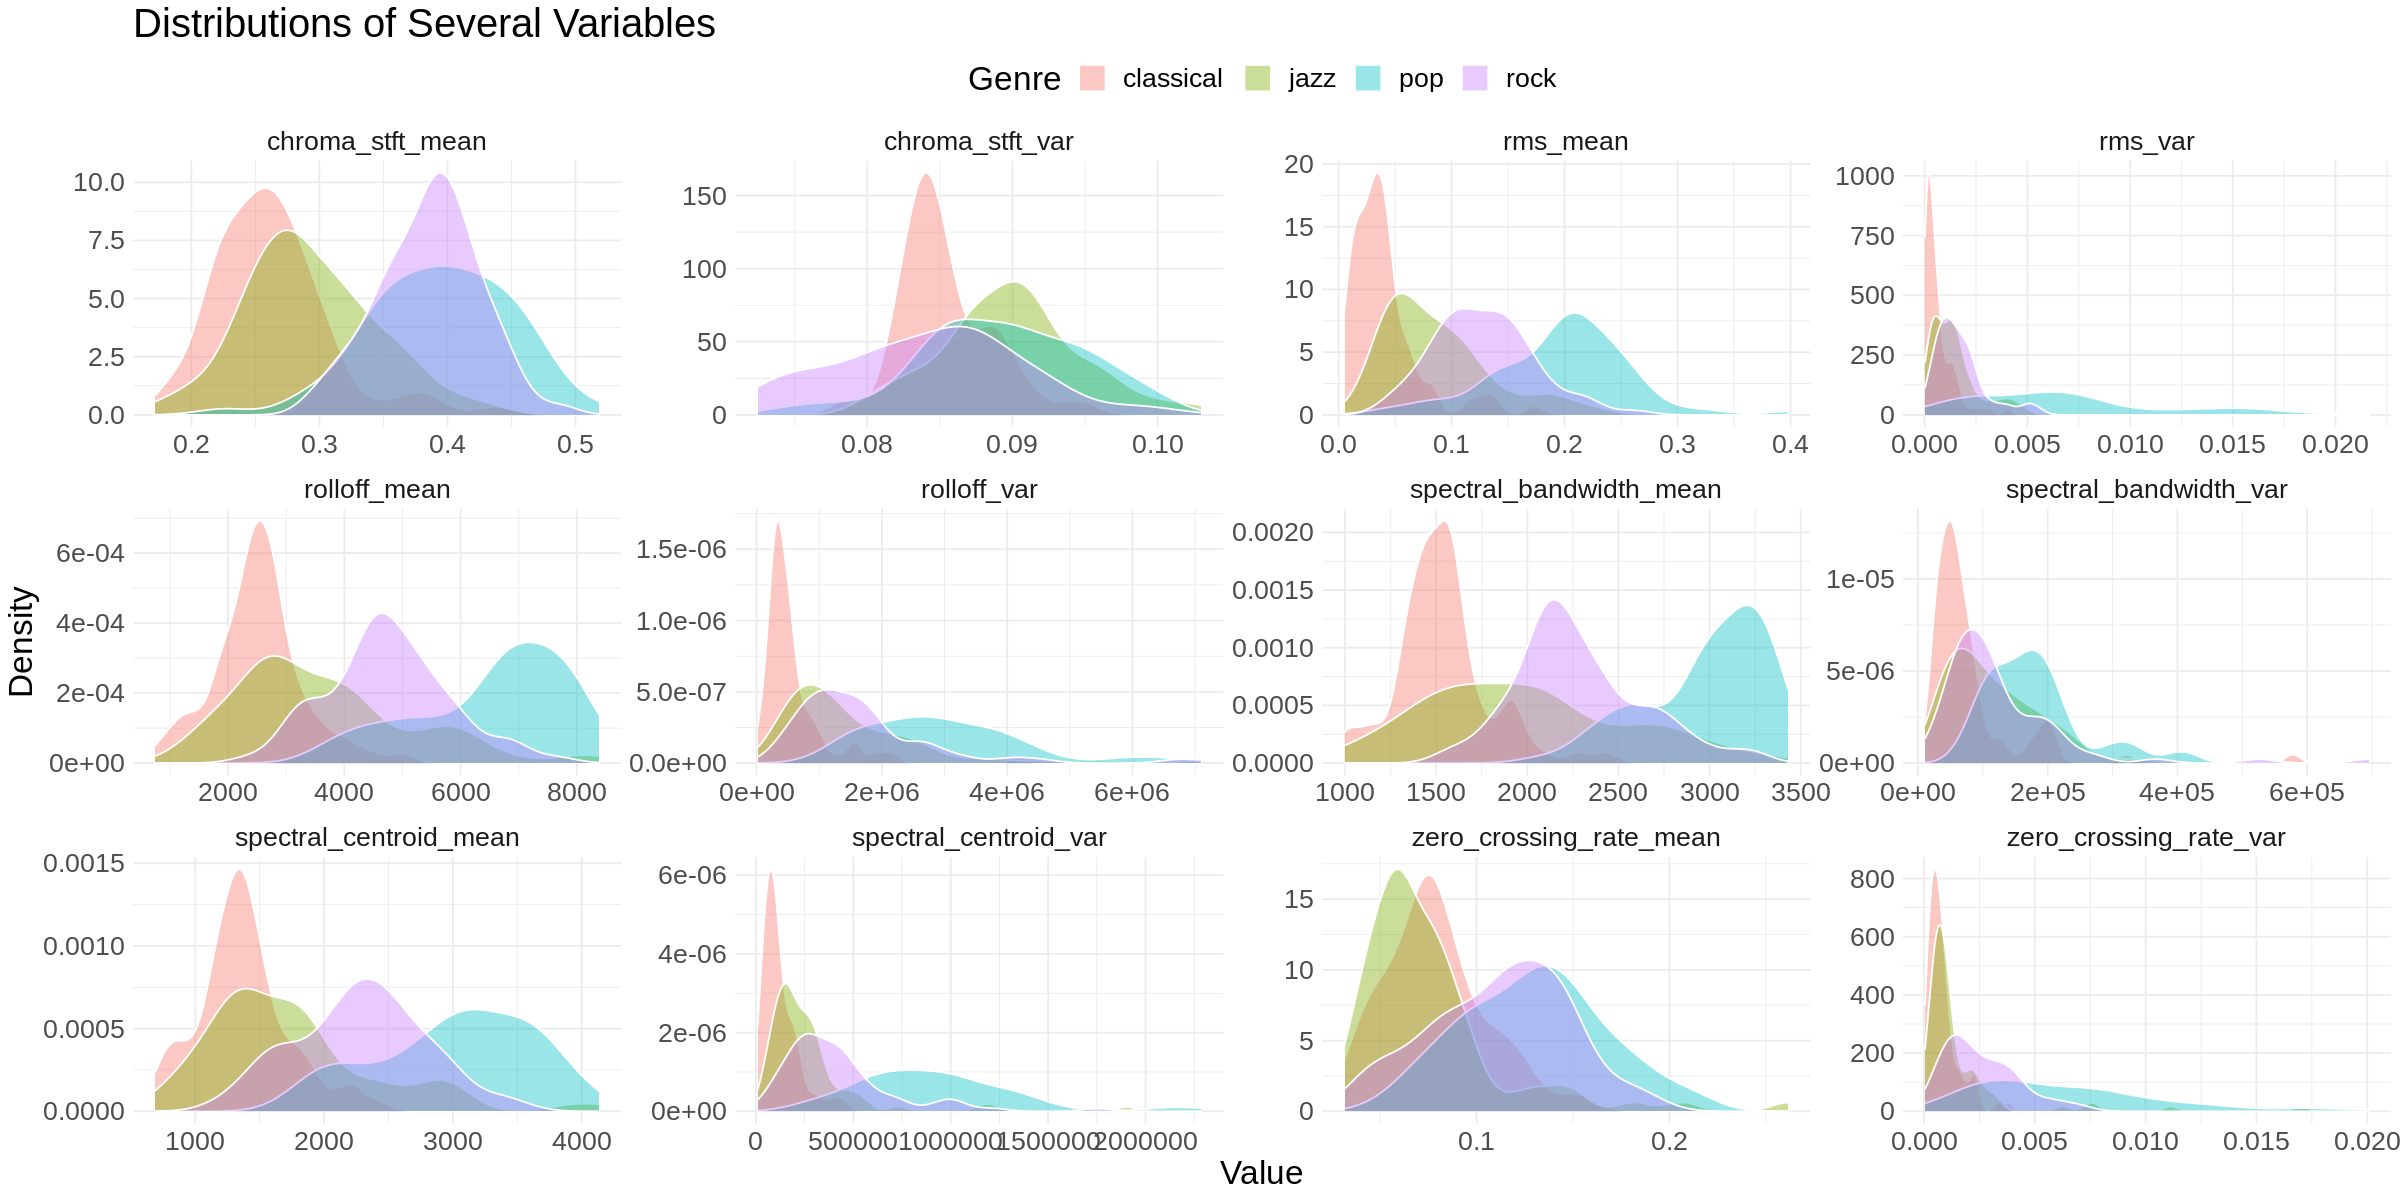

In [7]:
options(repr.plot.height = 10, repr.plot.width = 20)

music_training_data |>
    pivot_longer(cols = -label, names_to = "category", values_to = "value")  |> 
    ggplot(aes(x = value, fill = label)) +
        geom_density(alpha = 0.4, colour = "white") +
        facet_wrap(facets = vars(category), scales = "free") +
        labs(title = "Distributions of Several Variables",
             x = "Value", y = "Density", fill = "Genre") +
        theme_minimal() +
        theme(text = element_text(size = 20), legend.pos = "top")

From the above figure, we observe that the variables `chroma_stft_mean`, `rms_mean`, `rolloff_mean`, `spectral_bandwidth_mean`, and `spectral_centroid_mean` seem to have relatively different values for each genre. These variables are potentially strong predictors for KNN classification. 

The other variables have fairly similar values regardless of genre and may impede the KNN classification algorithm. However, the exact subset of predictors to use will be quantitatively verified with forward selection.

### Data Analysis
The data analysis includes:
1. Selecting predictors with forward selection;
2. Visualizing selected predictor variables; and
3. Selecting a $k$-value.
4. Evaluating the tuned KNN classification model.

### 1. Selecting predictors with forward selection
Due to the complexity and high number of variables, it is difficult to determine which ones will produce the most accurate KNN classification model. As such, we perform forward selection on all variables to choose the subset that results in the highest accuracy. 

In general, the algorithm has the following steps:
1. Start with no predictor variables.
2. For each untested predictor variable, temporarily add it to the model and compute its new accuracy with cross-validation.
3. Select the variable that produces in the highest accuracy and add it to the model.
4. Repeat steps 2 and 3 until all variables have been tested.

Note that this process is extremely slow and computationally heavy. To prevent the notebook from hanging, the code for predictor selection will not run unless you set the `run_predictor_selection` variable below to `TRUE`.

In [8]:
run_predictor_selection <- FALSE

In [9]:
set.seed(4545)

if (run_predictor_selection) {
    # create an empty tibble to store the results
    names <- VARIABLES
    kvals <- tibble(neighbors = seq(from = 1, to = 30, by = 1))
    accuracies <- tibble(size = integer(), model_string = character(), accuracy = numeric())

    # create a model specification
    knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
         set_engine("kknn") |>
         set_mode("classification")

    # store the total number of predictors
    n_total <- length(names)

    # stores selected predictors
    selected <- c()

    # for every size from 1 to the total number of predictors
    for (i in 1:n_total) {
        # for every predictor still not added yet
        accs <- list()
        models <- list()
        neighbors <- list()

        for (j in 1:length(names)) {
            # create a model string for this combination of predictors
            preds_new <- c(selected, names[[j]])
            model_string <- paste("label", "~", paste(preds_new, collapse = " + "))

            # create a recipe from the model string
            music_recipe <- recipe(as.formula(model_string), data = music_training_data) |>
                step_scale(all_predictors()) |>
                step_center(all_predictors())

            # tune the KNN classifier with these predictors, 
            # and collect the accuracy for the best K
            acc <- workflow() |>
              add_recipe(music_recipe) |>
              add_model(knn_spec) |>
              tune_grid(resamples = music_vfold, grid = kvals) |>
              collect_metrics() |>
              filter(.metric == "accuracy") |>
              arrange(desc(mean)) |>
              slice(1) |>
              select(mean, neighbors)

            acc <- acc$mean |> unlist()

            # add this result to the dataframe
            accs[[j]] <- acc
            models[[j]] <- model_string
        }

        jstar <- which.max(unlist(accs))
        accuracies <- accuracies |> 
            add_row(size = i, model_string = models[[jstar]], accuracy = accs[[jstar]])

        selected <- c(selected, names[[jstar]])
        names <- names[-jstar]
    }

    best_params <- accuracies |>
        arrange(desc(accuracy)) 

    best_params
}

From the results of the forward selection process, we find that the optimal recipe is:

```
label ~ rms_mean + spectral_bandwidth_mean + chroma_stft_mean + zero_crossing_rate_mean + rms_var + zero_crossing_rate_var
```

Overall, the recipe contains several of the strong predictors identified in the preliminary visualization stage. However, it also includes the less visually obvious variables `zero_crossing_rate_mean`, `rms_var`, and `zero_crossing_rate_var`. 

From a musical perspective, it can be interpreted that volume, frequency range, chromatic range, and certain characteristics of rhythm make up the defining traits of specific music genres.

!TODO more explanation

#### 2. Visualizing selected predictor variables
A scatter plot matrix is used to better understand the relationship between the optimal predictor variables.

## try using a parallel coordinates graph if someone can get it working

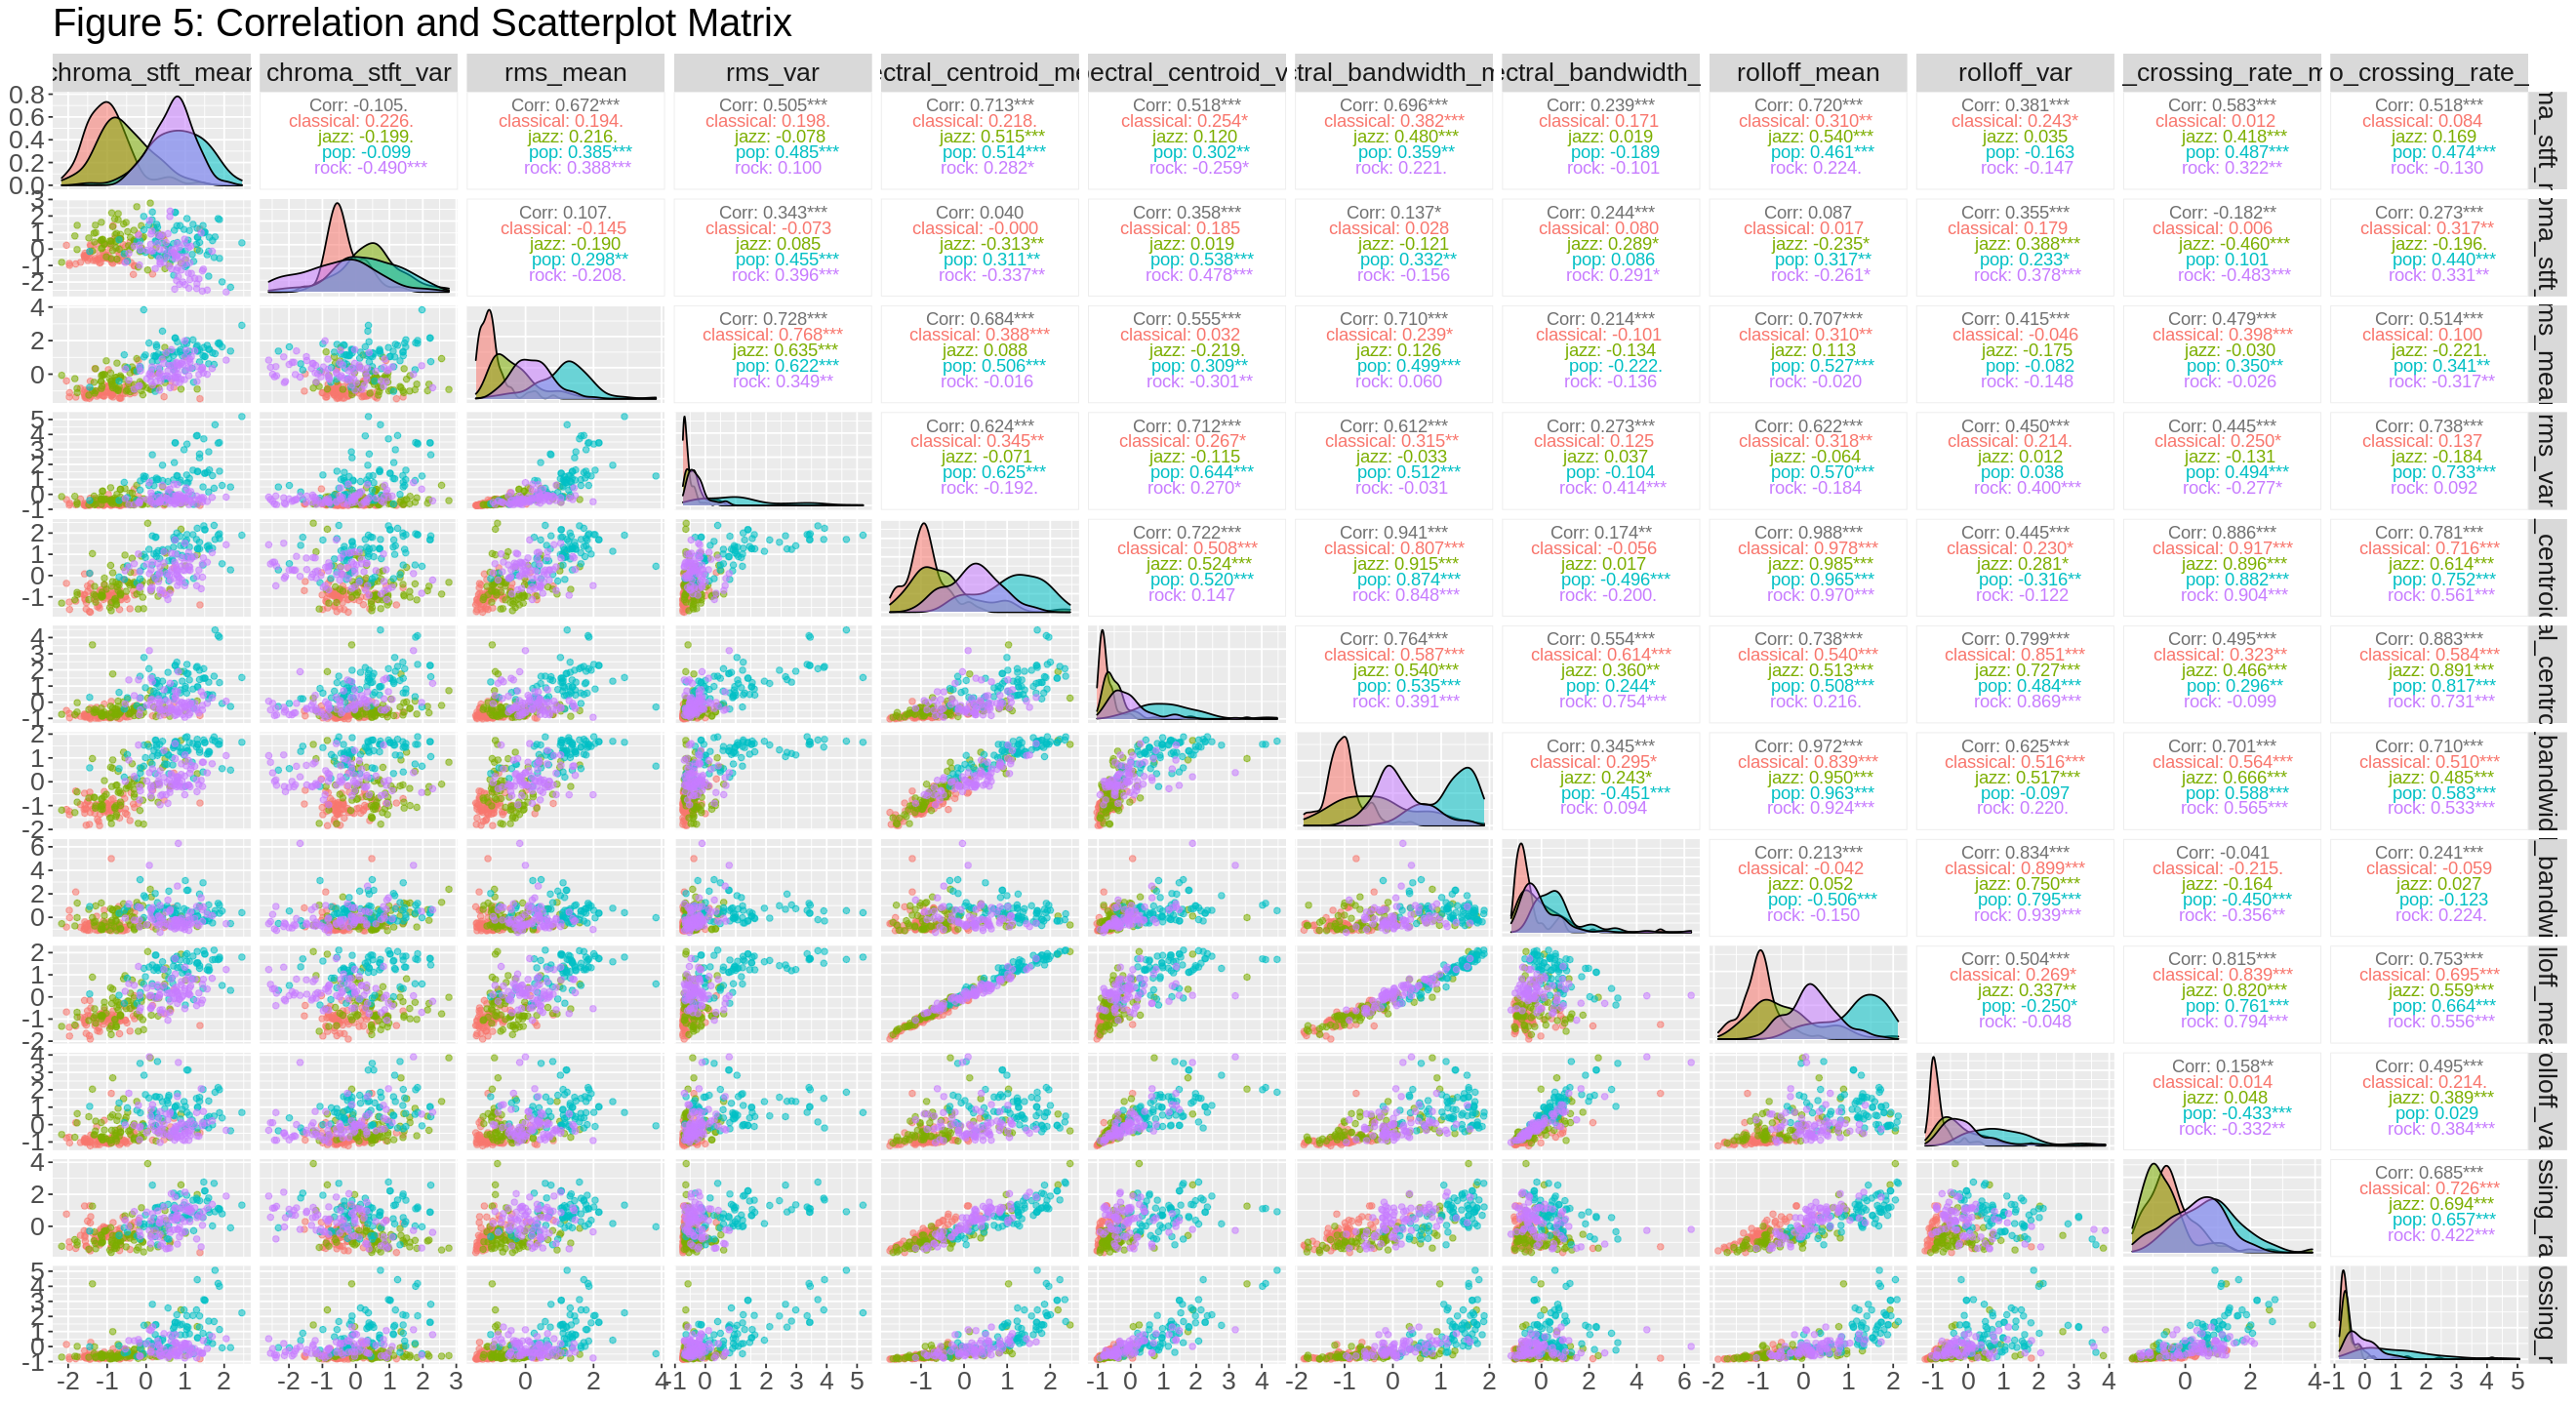

In [11]:
options(repr.plot.height = 12, repr.plot.width = 22)

music_training_data |>
    select(-label) |>
    scale()  |>
    bind_cols(label = music_training_data$label) |>
    ggpairs(mapping = aes(alpha = 0.4, colour = label),
           columns = 1:(ncol(music_training_data) - 1)) + 
        ggtitle("Figure 5: Correlation and Scatterplot Matrix") +
        theme(text = element_text(size = 20))


## $K$-value Selection

Now that the optimal predictor set is determined, we move on to picking an optimal $K$ value for KNN classification. The `neighbors` parameter is tuned in the model and a value is selected from the accuracy plot.

In [12]:
set.seed(4545)
knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
    set_mode("classification") |>
    set_engine("kknn")

knn_recipe <- recipe(label ~ rms_mean+spectral_bandwidth_mean+chroma_stft_mean+zero_crossing_rate_mean+rms_var+zero_crossing_rate_var, 
                     data = music_training_data) |>
            step_scale(all_predictors()) |>
            step_center(all_predictors())

music_fit_tune <- workflow() |> 
    add_recipe(knn_recipe) |>
    add_model(knn_spec) |>
    tune_grid(resamples = music_vfold, grid = tibble(neighbors = seq(from = 1, to = 50, by = 1))) |>
    collect_metrics() |>
    filter(.metric == "accuracy") |>
    arrange(desc(mean))
    
head(music_fit_tune)

neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
5,accuracy,multiclass,0.8142857,10,0.02014378,Preprocessor1_Model05
3,accuracy,multiclass,0.8129464,10,0.02113357,Preprocessor1_Model03
19,accuracy,multiclass,0.8098214,10,0.01721566,Preprocessor1_Model19
20,accuracy,multiclass,0.8098214,10,0.01548191,Preprocessor1_Model20
4,accuracy,multiclass,0.8066964,10,0.01998762,Preprocessor1_Model04
18,accuracy,multiclass,0.8066964,10,0.01661144,Preprocessor1_Model18


<b><p style="text-align: left;">Figure 5.1: K Value Accuracies Table</p><b>

In [ ]:
options(repr.plot.height = 6, repr.plot.width = 9)
music_fit_tune |> ggplot(aes(x = neighbors, y = mean)) +
    geom_point() + 
    geom_line() +
    labs(x = "K-value", y = "Accuracy", title = "Accuracy Variation for Different K-values")

<b><p style="text-align: left;">Figure 5.2: K Value vs Accuracy Graph</p><b>

From the graph, we observe two distint peaks at $k = 5$ and $k = 20$. Both peaks are similar in accuracy, at $81.4\%$ and $80.9\%$ respectively. Although $K=5$ has a marginally higher accuracy, it may be too small given the size of the data set. As such, the initial peak at $k = 5$ could be an indication of overfitting, as the model is overly sensitive to the noise in the training data. Moreover, a small $k$ value is at risk of increased variance, as individual points in the training data can exert a large influence on the final decision. To prevent poor generalization and find a balance between variance and accuracy, $k = 20$ is chosen.

It's important to note that the choice of $k$ in KNN classification is not dependent on the number of features or classes in the data. It is solely determined by the number of training samples and the desired trade-off between bias and variance. To optimize the model further, more new testing data is needed to verify the accuracy of the predictions


In [ ]:
tuned_knn <- nearest_neighbor(weight_func = "rectangular", neighbors = 20) |> 
    set_engine("kknn") |> 
    set_mode("classification")

tuned_workflow <- workflow() |> add_recipe(knn_recipe) |> add_model(tuned_knn) |> fit(data = music_training_data)



In [ ]:
music_preds <- tuned_workflow |> predict(music_testing_data) |> bind_cols(music_testing_data)
music_confusion_matrix <- music_preds |> conf_mat(truth = label, estimate = .pred_class)
music_metrics <- music_preds |> metrics(truth = label, estimate = .pred_class) |> filter(.metric == "accuracy")
music_metrics 

<p style="text-align: left;"> <b>Figure 6: <b> Music Prediction Accuracy</p>

In [ ]:
music_confusion_matrix

<b><p style="text-align: left;">Figure 7: Music Predictions Confusion Matrix</p> <b>

# Discussion

Based on our testing data, the K-Nearest-Neighbours model correctly predicts the category of music based off its spectrograph information approximately 75% of the time. For a data set with 4 categories of classification, this is significantly better than the majority classifier of 25%, and yields credence towards the hypothesis that we can in fact predict the genre of music based on its spectrograph information. 

We have discovered that ...

Taking a look at the confusion matrix, we see that the model had a difficult time predicting Jazz, often times mistaking it for classical and rock. Perhaps this is unsurprising as Jazz is known for its formless nature, and often has less of a distinct structure compared to the other genres, making it difficult even for a machine to classify. Originally, we sought to gain a deeper understanding of the distinguishing informative and discriminative characteristics of music genres, and the larger relative misclassification of Jazz implies that it's lack of these informative and discriminative features make it difficult to classify. 

In a similar study conducted by Agrawal on the same data set using KNN with 5 neighbors, their model had a testing accuracy of 70.67%. In the study, they performed the classification on all the available predictors, while in this study, predictor selection was employed to optimize the predictors used. The increase in model accuracy by 5% is a significant increase over the other study, and suggests that the methodology is valid. 


### Potential Impacts
Overall, the findings can have practical implications in the music industry such as streaming services that can train recommendation models on a user's music taste and deliver musical recommendations curated to their tastes, enhacing music discovery and user experience. In addition, these findings can help improve musical analysis, and assist music production processes by automating 

### Future Questions
- How does the performance of KNN classification compare to other algorithms for genre classification?

Various other studies such as one conducted by Ceylan use convolutional neural networks to make their classifications, achieving testing accuracies from 82.1% to 92.0%. Given the simplistic nature of our KNN model, it is surprising to see that its results were competitive even against convolutional neural networks which are much more computationally expensive and difficult to train.

- How can genre classification models handle songs that contain elements of multiple genres or blur genre boundaries?

- If 
- Given that it is possible for a machine to classify genre based on its spectrograph information, could an AI generate sounds that matches the characteristics of a genre to create  music?



## References

Ceylan, H. C., Hardalaç, N., Kara, A. C., &amp; Hardalaç, F. (2021). Automatic Music Genre Classification and Its Relation with Music Education. World Journal of Education, 11(2). https://doi.org/10.5430/wje.v11n2p36 

Agrawal, R. (2022, April 6). Music Genre Classification Project Using Machine Learning Techniques. Analytics Vidhya. https://www.analyticsvidhya.com/blog/2022/03/music-genre-classification-project-using-machine-learning-techniques/ 
